In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1306.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1466.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1410.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1479.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1689.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1818.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1721.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1548.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1812.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1402.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1236.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1627.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1724.JPG
/kaggle/input/orgial-dataset-arsenic/Original/infacted/IMG_1895.JPG
/kaggle/input/orgial-dataset-arsenic/Original/in

# Import file

In [2]:
import os
import glob
import shutil
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import GroupShuffleSplit
import torchvision.transforms as T
import cv2



# DATASET PATH VERIFICATION

In [3]:
# ============================================================
# STEP 1: DATASET PATH VERIFICATION
# ============================================================
data_dir = '/kaggle/input/orgial-dataset-arsenic/Original'
print("Dataset path:", data_dir)
print("Exists:", os.path.exists(data_dir))
print("Subfolders:", os.listdir(data_dir))

# Optional: Copy to local path for faster I/O
local_dir = '/content/Original_Data'
if not os.path.exists(local_dir):
    shutil.copytree(data_dir, local_dir)
    print("Dataset copied locally to:", local_dir)
else:
    print("Local dataset already exists at:", local_dir)

BASE_PATH = local_dir

filepaths = []
labels = []
groups = [] 


for label in os.listdir(BASE_PATH):
    label_path = os.path.join(BASE_PATH, label)
    if os.path.isdir(label_path):
        for fname in os.listdir(label_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(label_path, fname))
                labels.append(label)
                groups.append(label)  


df = pd.DataFrame({
    "filepath": filepaths,
    "label": labels,
    "group": groups
})

print("Total samples:", len(df))
print(df.head())

Dataset path: /kaggle/input/orgial-dataset-arsenic/Original
Exists: True
Subfolders: ['infacted', 'not_infacted']
Dataset copied locally to: /content/Original_Data
Total samples: 1287
                                            filepath         label  \
0  /content/Original_Data/not_infacted/IMG2023061...  not_infacted   
1  /content/Original_Data/not_infacted/IMG2023080...  not_infacted   
2  /content/Original_Data/not_infacted/IMG2023080...  not_infacted   
3  /content/Original_Data/not_infacted/IMG2023061...  not_infacted   
4  /content/Original_Data/not_infacted/IMG2023080...  not_infacted   

          group  
0  not_infacted  
1  not_infacted  
2  not_infacted  
3  not_infacted  
4  not_infacted  


# CLASS DETECTION FROM FOLDER NAMES

In [4]:
available_classes = [f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))]
print("Available class folders:", available_classes)

if not available_classes:
    raise ValueError("No class folders found. Check dataset path.")

CLASSES = available_classes

Available class folders: ['not_infacted', 'infacted']


# COMPUTE IMAGE STATISTICS


In [5]:
def compute_image_stats(image):
    if image.mode != "RGB":
        image = image.convert("RGB")

    arr = np.asarray(image, dtype=np.float32) / 255.0
    hsv = np.asarray(image.convert("HSV"), dtype=np.float32) / 255.0

    stats = {}
    for i, c in enumerate(['R', 'G', 'B']):
        stats[f'{c}_mean'] = arr[:, :, i].mean()
        stats[f'{c}_std'] = arr[:, :, i].std()
    for i, c in enumerate(['H', 'S', 'V']):
        stats[f'{c}_mean'] = hsv[:, :, i].mean()
        stats[f'{c}_std'] = hsv[:, :, i].std()

    stats['brightness'] = hsv[:, :, 2].mean()
    stats['contrast'] = arr.std(axis=(0,1)).mean()

    s = hsv[:, :, 1]
    stats['sat_clip_low'] = np.mean(s < 0.05)
    stats['sat_clip_high'] = np.mean(s > 0.95)

    stats['width'], stats['height'] = image.size
    stats['aspect_ratio'] = image.width / image.height

    return stats

rows = []
MAX_IMAGES = None  # Set to a number for testing (e.g., 200)

for cls in CLASSES:
    folder = os.path.join(BASE_PATH, cls)
    img_paths = glob.glob(os.path.join(folder, "*.*"))
    if MAX_IMAGES:
        img_paths = img_paths[:MAX_IMAGES]

    if not img_paths:
        print(f"No images found in folder: {folder}")
        continue

    print(f"Processing {len(img_paths)} images in class '{cls}'...")
    for path in tqdm(img_paths, desc=f"{cls} images"):
        if not path.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            continue
        try:
            img = Image.open(path)
            stats = compute_image_stats(img)
            stats["class"] = cls
            stats["filename"] = os.path.basename(path)
            rows.append(stats)
        except:
            continue

if not rows:
    raise ValueError("No valid images found. Check dataset path or folder structure.")

df_stats = pd.DataFrame(rows)
print("Total images processed:", len(df_stats))
display(df_stats.head())

Processing 546 images in class 'not_infacted'...


not_infacted images:   0%|          | 0/546 [00:00<?, ?it/s]

Processing 741 images in class 'infacted'...


infacted images:   0%|          | 0/741 [00:00<?, ?it/s]

Total images processed: 1287


,R_mean,R_std,G_mean,G_std,B_mean,B_std,H_mean,H_std,S_mean,S_std,...,V_std,brightness,contrast,sat_clip_low,sat_clip_high,width,height,aspect_ratio,class,filename
0,0.695316,0.088976,0.572566,0.088561,0.451598,0.090655,0.080867,0.005082,0.354899,0.062826,...,0.088976,0.695316,0.093286,1.371910e-06,4.913934e-05,3468,4624,0.75,not_infacted,IMG20230610181733.jpg
1,0.577354,0.080682,0.503701,0.082955,0.405659,0.083312,0.093330,0.004695,0.302068,0.050794,...,0.080682,0.577354,0.086205,0.000000e+00,0.000000e+00,3468,4624,0.75,not_infacted,IMG20230807183520.jpg
2,0.633974,0.059775,0.607313,0.069123,0.567375,0.078073,0.105668,0.033857,0.106743,0.056050,...,0.059873,0.634150,0.076029,1.479995e-01,0.000000e+00,3468,4624,0.75,not_infacted,IMG20230807183123.jpg
3,0.707919,0.082438,0.577458,0.084216,0.462828,0.086566,0.075615,0.006143,0.350953,0.071282,...,0.082438,0.707919,0.086152,3.117978e-05,9.131935e-04,3468,4624,0.75,not_infacted,IMG20230610181308.jpg
4,0.573293,0.057554,0.544498,0.059090,0.499595,0.060271,0.099822,0.009901,0.128594,0.023085,...,0.057554,0.573294,0.060929,1.870787e-07,6.235957e-08,3468,4624,0.75,not_infacted,IMG20230807183248.jpg


# HISTOGRAM VISUALIZATION 

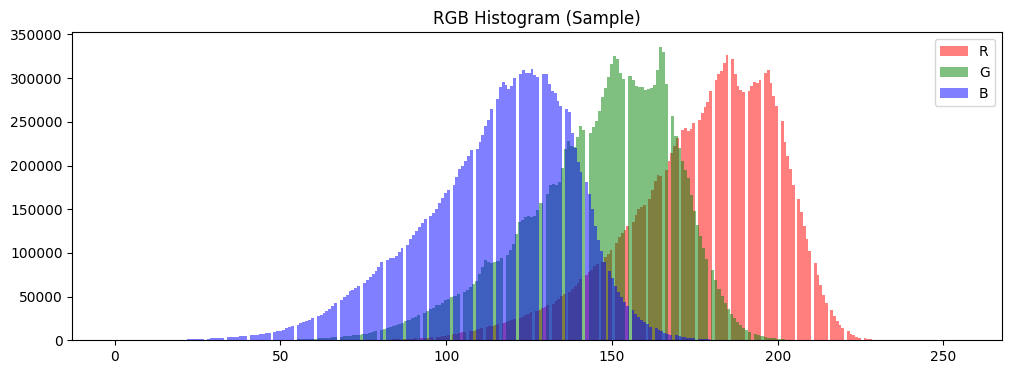

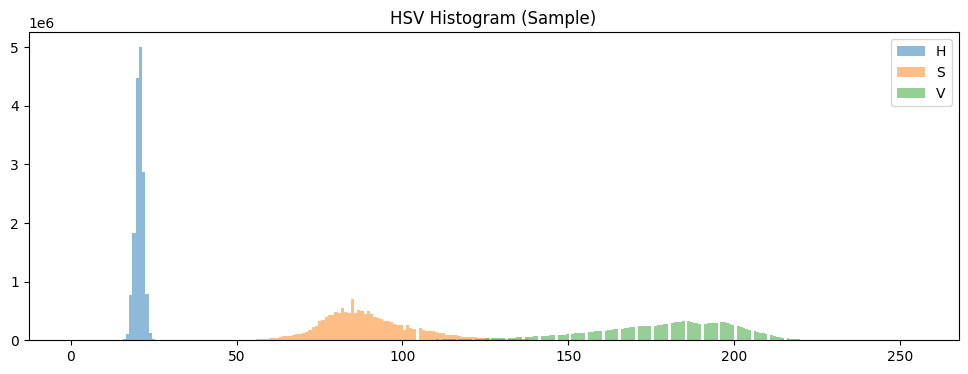

In [6]:
sample_row = df_stats.iloc[0]
sample_img_path = os.path.join(BASE_PATH, sample_row["class"], sample_row["filename"])
sample_img = Image.open(sample_img_path)
arr = np.asarray(sample_img)

plt.figure(figsize=(12,4))
for i,color in enumerate(['r','g','b']):
    plt.hist(arr[:,:,i].ravel(), bins=256, color=color, alpha=0.5, label=color.upper())
plt.title("RGB Histogram (Sample)")
plt.legend()
plt.show()

hsv = np.asarray(sample_img.convert("HSV"))
plt.figure(figsize=(12,4))
for i,color in enumerate(['h','s','v']):
    plt.hist(hsv[:,:,i].ravel(), bins=256, alpha=0.5, label=color.upper())
plt.title("HSV Histogram (Sample)")
plt.legend()
plt.show()

# PER-CLASS SUMMARY STATISTICS

Per-Class Mean & STD:


R_mean               R_std              G_mean            \
                  mean       std      mean       std      mean       std   
class                                                                      
infacted      0.684950  0.081812  0.140340  0.037378  0.545283  0.061217   
not_infacted  0.659803  0.077076  0.100049  0.039741  0.569448  0.080927   

                 G_std              B_mean            ... sat_clip_low  \
                  mean       std      mean       std  ...         mean   
class                                                 ...                
infacted      0.139184  0.035920  0.456526  0.059377  ...     0.008509   
not_infacted  0.106481  0.042616  0.496035  0.083903  ...     0.029440   

                       sat_clip_high                  width              \
                   std          mean       std         mean         std   
class                                                                     
infacted      0.029280      0.001327  0.005978  4032.000000     0.00000   
not_infacted  0.083165      0.001277  0.004610  3196.294872  1047.82375   

                   height              aspect_ratio            
                     mean          std         mean       std  
class                                                          
infacted      3024.000000     0.000000     1.333333  0.000000  
not_infacted  3656.826007  1244.889474     0.929098  0.386921  

[2 rows x 38 columns]

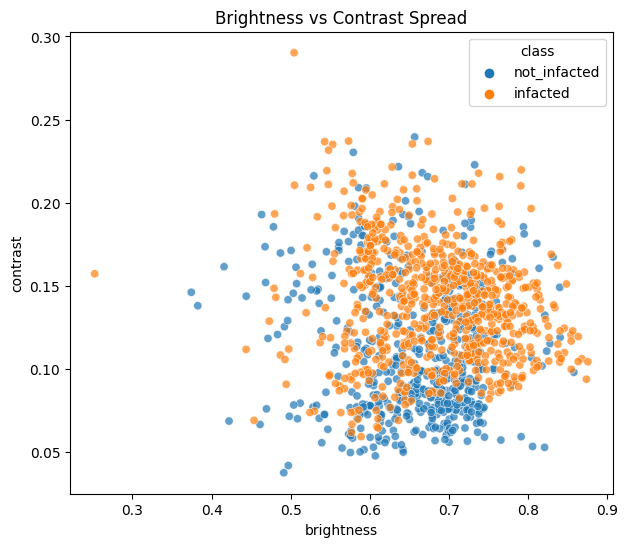

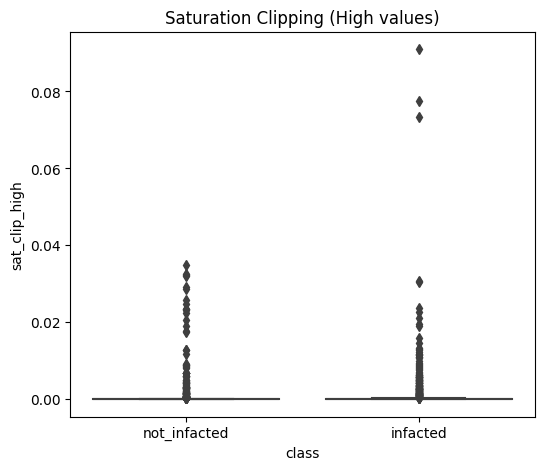

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

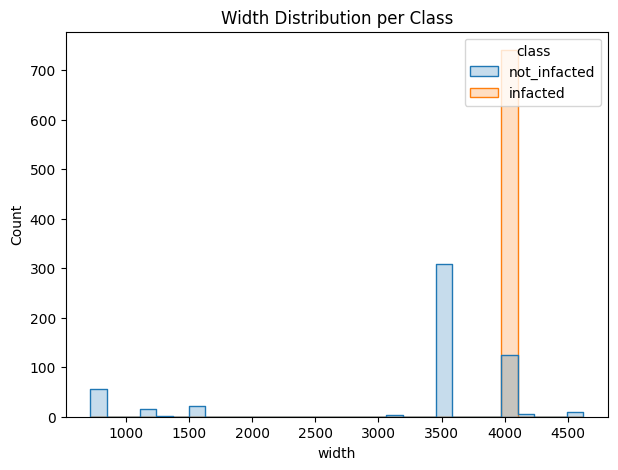

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

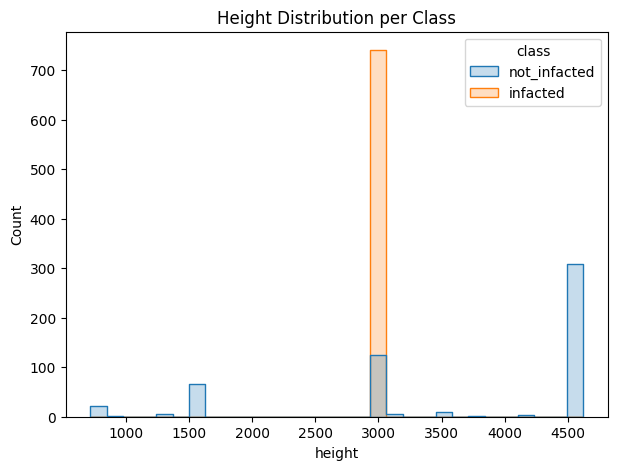

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

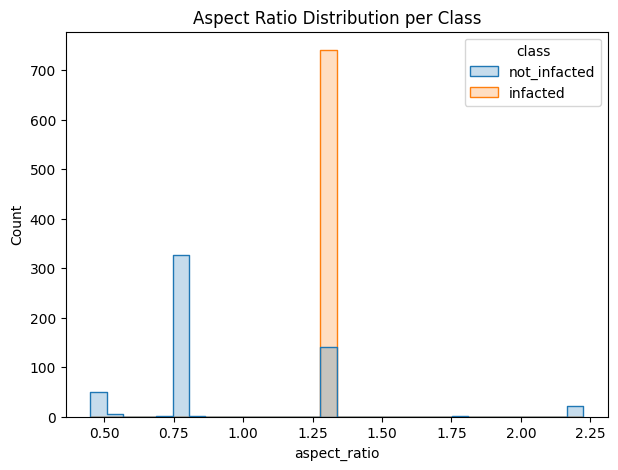

Suggested resize target: (3677x3292)

Suggested Strategy:
- Resize all images to a fixed size (e.g., 256×256)
- Maintain aspect ratio by padding (black or mean color)
- For CNNs, use random crop + resize augmentation



In [7]:
numeric_cols = df_stats.select_dtypes(include=np.number).columns.tolist()
summary = df_stats.groupby("class")[numeric_cols].agg(["mean","std"])
print("Per-Class Mean & STD:")
display(summary)

# Brightness vs Contrast
plt.figure(figsize=(7,6))
sns.scatterplot(data=df_stats, x="brightness", y="contrast", hue="class", alpha=0.7)
plt.title("Brightness vs Contrast Spread")
plt.show()

# Saturation Clipping
plt.figure(figsize=(6,5))
sns.boxplot(data=df_stats, x="class", y="sat_clip_high")
plt.title("Saturation Clipping (High values)")
plt.show()

# Resolution and Aspect Ratio
plt.figure(figsize=(7,5))
sns.histplot(data=df_stats, x="width", bins=30, hue="class", element="step")
plt.title("Width Distribution per Class")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df_stats, x="height", bins=30, hue="class", element="step")
plt.title("Height Distribution per Class")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df_stats, x="aspect_ratio", bins=30, hue="class", element="step")
plt.title("Aspect Ratio Distribution per Class")
plt.show()

# Suggested Resize Target
mean_w, mean_h = df_stats['width'].mean(), df_stats['height'].mean()
print(f"Suggested resize target: ({int(mean_w)}x{int(mean_h)})")
print("""
Suggested Strategy:
- Resize all images to a fixed size (e.g., 256×256)
- Maintain aspect ratio by padding (black or mean color)
- For CNNs, use random crop + resize augmentation
""")

# IMAGE QUALITY METRICS (LAPLACIAN VARIANCE & NOISE)

In [8]:
def laplacian_variance(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    lap = cv2.Laplacian(img, cv2.CV_64F)
    return lap.var()

def noise_proxy(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    noise = img.astype("float") - blurred.astype("float")
    return noise.var()

categories = CLASSES
quality_data = []

for category in categories:
    folder_path = os.path.join(BASE_PATH, category)
    for filename in tqdm(os.listdir(folder_path), desc=f"Quality check: {category}"):
        img_path = os.path.join(folder_path, filename)
        lap_var = laplacian_variance(img_path)
        noise_val = noise_proxy(img_path)
        quality_data.append({
            'filename': filename,
            'category': category,
            'laplacian_variance': lap_var,
            'noise_proxy': noise_val
        })

df_quality = pd.DataFrame(quality_data)
output_csv = '/content/laplacian_noise_results.csv'
df_quality.to_csv(output_csv, index=False)
print("CSV saved to:", output_csv)
print(df_quality.groupby('category')[['laplacian_variance', 'noise_proxy']].mean())


Quality check: not_infacted:   0%|          | 0/546 [00:00<?, ?it/s]

Quality check: infacted:   0%|          | 0/741 [00:00<?, ?it/s]

CSV saved to: /content/laplacian_noise_results.csv
              laplacian_variance  noise_proxy
category                                     
infacted               22.096996     1.227764
not_infacted           30.358032     1.568775


# DUPLICATE DETECTION (Perceptual Hashing)

In [9]:
def gray_world_correction(pil_image):
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    arr = np.asarray(pil_image).astype(np.float32)
    mean_r, mean_g, mean_b = arr[:,:,0].mean(), arr[:,:,1].mean(), arr[:,:,2].mean()
    mean_gray = (mean_r + mean_g + mean_b) / 3.0
    arr[:,:,0] = np.clip(arr[:,:,0] * (mean_gray / mean_r), 0, 255)
    arr[:,:,1] = np.clip(arr[:,:,1] * (mean_gray / mean_g), 0, 255)
    arr[:,:,2] = np.clip(arr[:,:,2] * (mean_gray / mean_b), 0, 255)
    return Image.fromarray(arr.astype(np.uint8))

def ahash(image, hash_size=8):
    image = image.convert('L').resize((hash_size, hash_size), Image.Resampling.LANCZOS)
    pixels = np.array(image)
    avg = pixels.mean()
    return ''.join(['1' if p > avg else '0' for p in pixels.flatten()])

def dhash(image, hash_size=8):
    image = image.convert('L').resize((hash_size + 1, hash_size), Image.Resampling.LANCZOS)
    pixels = np.array(image)
    diff = pixels[:, 1:] > pixels[:, :-1]
    return ''.join(['1' if v else '0' for v in diff.flatten()])

def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

image_paths = glob.glob(os.path.join(BASE_PATH, '**', '*.*'), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
print("Total image paths found:", len(image_paths))

rows = []
for img_path in tqdm(image_paths, desc="Perceptual hashing"):
    try:
        img = Image.open(img_path)
        row = {
            "filename": os.path.basename(img_path),
            "path": img_path,
            "ahash": ahash(img),
            "dhash": dhash(img)
        }
        rows.append(row)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

if not rows:
    print("No valid image data found.")
else:
    df_hash = pd.DataFrame(rows)
    df_hash = df_hash.sort_values("filename").reset_index(drop=True)
    print("Hash DataFrame:")
    display(df_hash.head())

    duplicates = []
    threshold = 5
    for (i1, row1), (i2, row2) in itertools.combinations(df_hash.iterrows(), 2):
        hd_ahash = hamming_distance(row1['ahash'], row2['ahash'])
        hd_dhash = hamming_distance(row1['dhash'], row2['dhash'])
        if hd_ahash <= threshold and hd_dhash <= threshold:
            duplicates.append({
                "file1": row1['filename'],
                "file2": row2['filename'],
                "ahash_dist": hd_ahash,
                "dhash_dist": hd_dhash
            })

    dup_df = pd.DataFrame(duplicates)
    if not dup_df.empty:
        print("Duplicates found:")
        display(dup_df)
    else:
        print("No duplicates detected.")

Total image paths found: 1287


Perceptual hashing:   0%|          | 0/1287 [00:00<?, ?it/s]

Hash DataFrame:


,filename,path,ahash,dhash
0,IMG-20230529-WA0000.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000000000000000000000011000011111011111111111...,1011011111101010011011110011110100110100100101...
1,IMG-20230529-WA0001.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000111100111111011011010100110100010111000101...,0111101101101111110110011101100111110100011101...
2,IMG-20230529-WA0002.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000011100001111000001110000011100001111000011...,1111111011111110011111101110111011101100111011...
3,IMG-20230529-WA0003.jpg,/content/Original_Data/not_infacted/IMG-202305...,0101111111001111110011101000000010000100000001...,1001101110011010000110100010100100111101001011...
4,IMG-20230529-WA0004.jpg,/content/Original_Data/not_infacted/IMG-202305...,0000111100001111000001110000011101111111111111...,1111111000111110111111101110111111011011110000...


Duplicates found:


,file1,file2,ahash_dist,dhash_dist
0,IMG-20230529-WA0019.jpg,IMG-20230529-WA0067.jpg,2,2
1,IMG-20230529-WA0021.jpg,IMG-20230529-WA0060.jpg,4,4
2,IMG-20230529-WA0021.jpg,IMG_20230612_130410.jpg,2,5
3,IMG-20230529-WA0042.jpg,IMG-20230529-WA0046.jpg,4,3
4,IMG-20230529-WA0042.jpg,IMG20230610182635.jpg,5,4
...,...,...,...,...
77,IMG_20230612_130815.jpg,IMG_20230612_130817.jpg,4,2
78,IMG_20230616_153459.jpg,IMG_20230616_153500.jpg,3,1
79,IMG_2025.JPG,IMG_2026.JPG,1,2
80,IMG_2074.JPG,IMG_2075.JPG,1,5


# DATAFRAME BUILDING & GROUPED TRAIN-TEST SPLIT

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

train_groups = []
test_groups = []

# Split safely per label
for lbl, sub_df in df.groupby("label"):
    groups = sub_df["group"].unique()
    n_groups = len(groups)

    if n_groups < 2:
        print(f" Label '{lbl}' has only {n_groups} group(s) — assigning all to train.")
        train_groups.extend(groups)
        continue

    # otherwise, do normal 80/20 split
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
    train_idx, test_idx = next(gss.split(groups, groups=groups))
    train_groups.extend(groups[train_idx])
    test_groups.extend(groups[test_idx])

# build full DataFrames
train_df = df[df["group"].isin(train_groups)].reset_index(drop=True)
test_df = df[df["group"].isin(test_groups)].reset_index(drop=True)

# print summary
print("\n Safe Label-wise Group Split Complete")
print("---------------------------------------")
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("Unique groups in train:", train_df["group"].nunique())
print("Unique groups in test:", test_df["group"].nunique())

print("\n Train class distribution:")
print(train_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# save csvs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)
print("\n Train/Test split CSVs saved in /kaggle/working/")


 Label 'infacted' has only 1 group(s) — assigning all to train.
 Label 'not_infacted' has only 1 group(s) — assigning all to train.

 Safe Label-wise Group Split Complete
---------------------------------------
Train size: 1287
Test size: 0
Unique groups in train: 2
Unique groups in test: 0

 Train class distribution:
label
infacted        741
not_infacted    546
Name: count, dtype: int64

Test class distribution:
Series([], Name: count, dtype: int64)

 Train/Test split CSVs saved in /kaggle/working/


# : AUGMENTATION PROBE

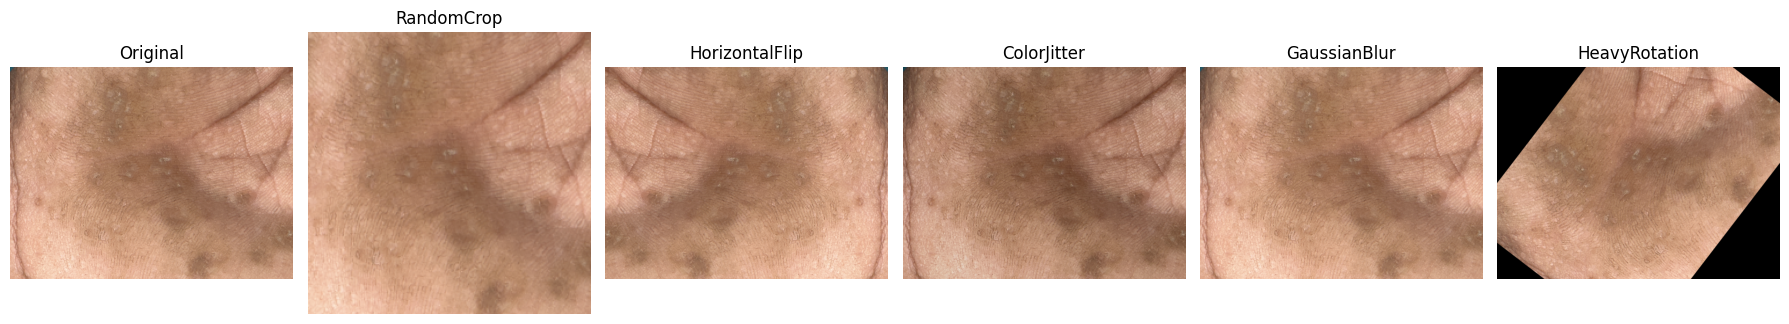

Augmentation probe complete. Visually inspect which transforms are helpful or harmful.


In [11]:
sample_path = train_df['filepath'].sample(1, random_state=42).iloc[0]
img = Image.open(sample_path)

augmentations = {
    "RandomCrop": T.RandomResizedCrop(size=244, scale=(0.8, 1.0)),
    "HorizontalFlip": T.RandomHorizontalFlip(p=1.0),
    "ColorJitter": T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    "GaussianBlur": T.GaussianBlur(kernel_size=5),
    "HeavyRotation": T.RandomRotation(degrees=90),
}

fig, axes = plt.subplots(1, len(augmentations)+1, figsize=(18,5))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

for i, (name, aug) in enumerate(augmentations.items(), 1):
    transformed = aug(img)
    axes[i].imshow(transformed)
    axes[i].set_title(name)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("Augmentation probe complete. Visually inspect which transforms are helpful or harmful.")

# Validation Split 
# train (90%)
# test (10%)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

# Train 90% + Test 10%
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)

# Validation = 10% of total dataset → 10 / 90 = 0.1111 of train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 1042
Validation size: 116
Test size: 129

Train class distribution:
label
infacted        600
not_infacted    442
Name: count, dtype: int64

Validation class distribution:
label
infacted        67
not_infacted    49
Name: count, dtype: int64

Test class distribution:
label
infacted        74
not_infacted    55
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version

2025-10-27 18:51:37.114470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761591097.305567      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761591097.357927      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1042 validated image filenames belonging to 2 classes.
Found 116 validated image filenames belonging to 2 classes.
Found 129 validated image filenames belonging to 2 classes.


I0000 00:00:1761591107.881704      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1761591133.884485      65 service.cc:148] XLA service 0x7fa270001960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761591133.885284      65 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761591135.652772      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/33 ━━━━━━━━━━━━━━━━━━━━ 9:31 18s/step - accuracy: 0.5000 - loss: 0.9789

I0000 00:00:1761591139.519639      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.5971 - loss: 0.8026 - val_accuracy: 0.5776 - val_loss: 0.6903
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5102 - loss: 0.7584 - val_accuracy: 0.5776 - val_loss: 0.6841
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.4980 - loss: 0.7477 - val_accuracy: 0.5776 - val_loss: 0.6825
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.5049 - loss: 0.7456 - val_accuracy: 0.5776 - val_loss: 0.6822
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5344 - loss: 0.7394 - val_accuracy: 0.5776 - val_loss: 0.6821
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.5163 - loss: 0.7355 - val_accuracy: 0.5776 - val_loss: 0.6818
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5703 - loss: 0.7083 - val_accuracy: 0.5776 - val_loss: 0.6815
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5184 - loss: 0.7202 - val_accuracy: 0.5776 - val_loss: 0.6815
Ep

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


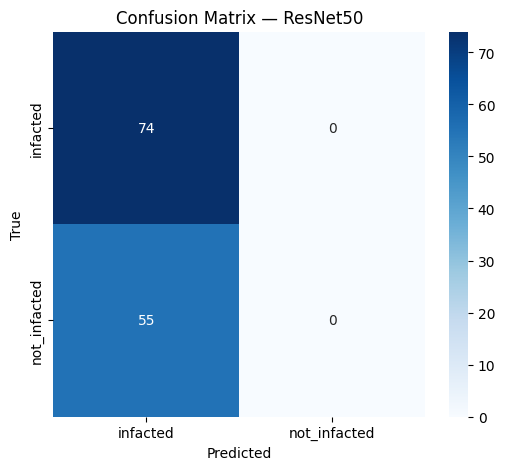

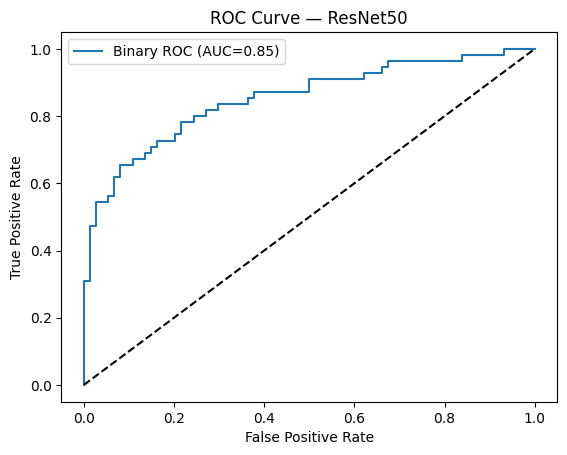


ROC–AUC: 0.8523


I0000 00:00:1761595560.291384      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761595560.291547      19 single_machine.cc:361] Starting new session
I0000 00:00:1761595560.292639      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (80%)
# test (20%)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)


train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)


# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 926
Validation size: 103
Test size: 258

Train class distribution:
label
infacted        533
not_infacted    393
Name: count, dtype: int64

Validation class distribution:
label
infacted        59
not_infacted    44
Name: count, dtype: int64

Test class distribution:
label
infacted        149
not_infacted    109
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version

Found 926 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.
Found 258 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.4825 - loss: 0.7891 - val_accuracy: 0.5728 - val_loss: 0.6789
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5306 - loss: 0.7711 - val_accuracy: 0.5728 - val_loss: 0.6794
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5220 - loss: 0.7428 - val_accuracy: 0.5728 - val_loss: 0.6792
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.5781 - loss: 0.7281 - val_accuracy: 0.5728 - val_loss: 0.6783
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5412 - loss: 0.7195 - val_accuracy: 0.5728 - val_loss: 0.6784
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5598 - loss: 0.6997 - val_accuracy: 0.5728 - val_loss: 0.6792
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5315 - loss: 0.7287 - val_accuracy: 0.5728 - val_loss: 0.6774
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5253 - loss: 0.7296 - val_accuracy: 0.5728 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


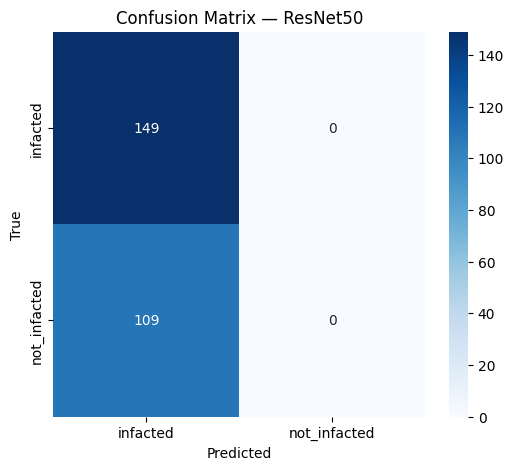

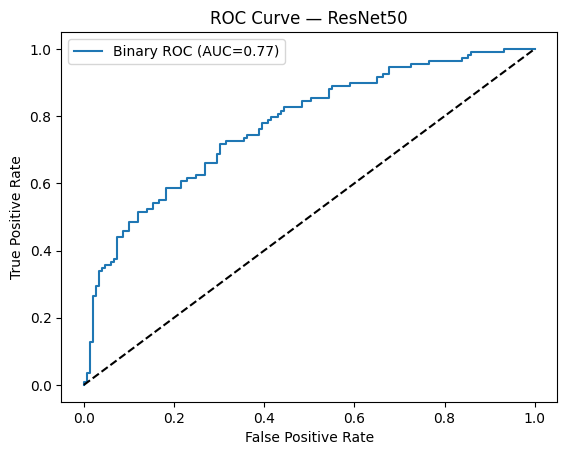


ROC–AUC: 0.7737


I0000 00:00:1761599502.304385      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761599502.304562      19 single_machine.cc:361] Starting new session
I0000 00:00:1761599502.305651      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (70%)
# test (30%)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label"],
    random_state=42
)

# Validation = 10% of total dataset → 10 / 70 ≈ 0.1429 of train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 810
Validation size: 90
Test size: 387

Train class distribution:
label
infacted        466
not_infacted    344
Name: count, dtype: int64

Validation class distribution:
label
infacted        52
not_infacted    38
Name: count, dtype: int64

Test class distribution:
label
infacted        223
not_infacted    164
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version

Found 810 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.
Found 387 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.5010 - loss: 0.7726 - val_accuracy: 0.5778 - val_loss: 0.6821
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4899 - loss: 0.7614 - val_accuracy: 0.5778 - val_loss: 0.6820
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.5010 - loss: 0.7576 - val_accuracy: 0.5778 - val_loss: 0.6819
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5260 - loss: 0.7151 - val_accuracy: 0.5778 - val_loss: 0.6817
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5504 - loss: 0.7209 - val_accuracy: 0.5778 - val_loss: 0.6818
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5432 - loss: 0.7213 - val_accuracy: 0.5778 - val_loss: 0.6815
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5424 - loss: 0.7239 - val_accuracy: 0.5778 - val_loss: 0.6819
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.5219 - loss: 0.7234 - val_accuracy: 0.5778 - val_loss:

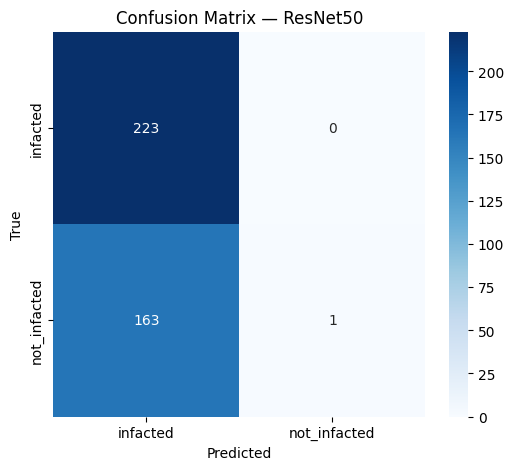

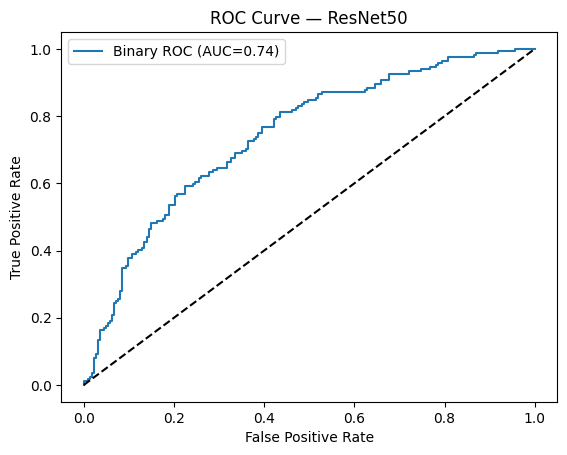


ROC–AUC: 0.7414


I0000 00:00:1761603000.035327      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761603000.035505      19 single_machine.cc:361] Starting new session
I0000 00:00:1761603000.036573      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (60%)
# test (40%)

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

train_df, test_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df["label"],
    random_state=42
)

# Validation = 10% of total dataset → 10 / 60 ≈ 0.1667 of train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 694
Validation size: 78
Test size: 515

Train class distribution:
label
infacted        399
not_infacted    295
Name: count, dtype: int64

Validation class distribution:
label
infacted        45
not_infacted    33
Name: count, dtype: int64

Test class distribution:
label
infacted        297
not_infacted    218
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version

Found 694 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4283 - loss: 0.9659 - val_accuracy: 0.4231 - val_loss: 0.7529
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.4748 - loss: 0.7761 - val_accuracy: 0.5769 - val_loss: 0.6900
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.4876 - loss: 0.7600 - val_accuracy: 0.5769 - val_loss: 0.6860
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.5159 - loss: 0.7533 - val_accuracy: 0.5769 - val_loss: 0.6866
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5326 - loss: 0.7577 - val_accuracy: 0.5769 - val_loss: 0.6856
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5327 - loss: 0.7186 - val_accuracy: 0.5769 - val_loss: 0.6855
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.4909 - loss: 0.7646 - val_accuracy: 0.5769 - val_loss: 0.6853
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.5189 - loss: 0.7429 - val_accuracy: 0.5769 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


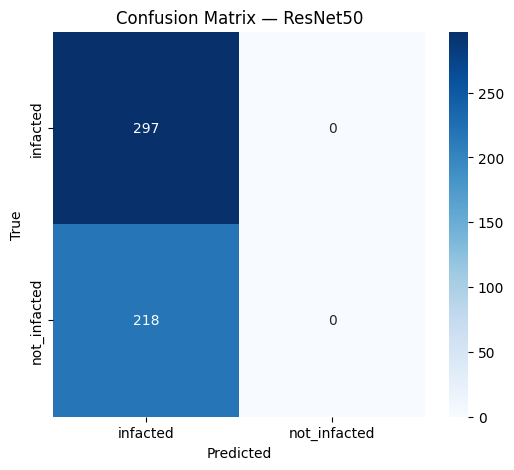

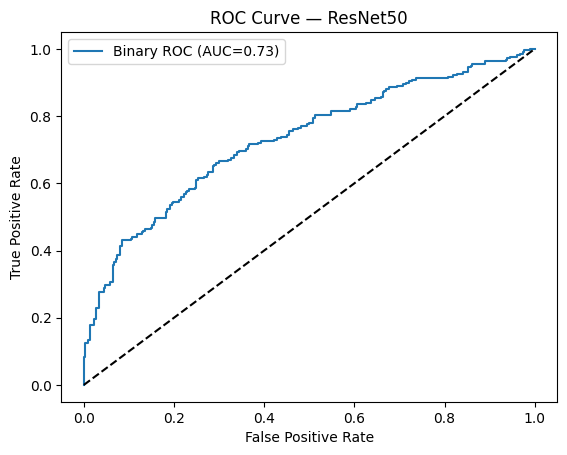


ROC–AUC: 0.7296


I0000 00:00:1761606024.568978      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761606024.569172      19 single_machine.cc:361] Starting new session
I0000 00:00:1761606024.570265      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (50%)
# test (50%)

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

train_df, test_df = train_test_split(
    df,
    test_size=0.5,
    stratify=df["label"],
    random_state=42
)

# Validation = 10% of total dataset → 10 / 50 = 0.2 of train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 578
Validation size: 65
Test size: 644

Train class distribution:
label
infacted        333
not_infacted    245
Name: count, dtype: int64

Validation class distribution:
label
infacted        37
not_infacted    28
Name: count, dtype: int64

Test class distribution:
label
infacted        371
not_infacted    273
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version

Found 578 validated image filenames belonging to 2 classes.
Found 65 validated image filenames belonging to 2 classes.
Found 644 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4539 - loss: 1.1575 - val_accuracy: 0.4308 - val_loss: 0.8743
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5025 - loss: 0.9173 - val_accuracy: 0.4308 - val_loss: 0.7384
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.4604 - loss: 0.8793 - val_accuracy: 0.5077 - val_loss: 0.6925
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4667 - loss: 0.8368 - val_accuracy: 0.5692 - val_loss: 0.6880
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5248 - loss: 0.8175 - val_accuracy: 0.5692 - val_loss: 0.6910
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5111 - loss: 0.8550 - val_accuracy: 0.5692 - val_loss: 0.6897
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5373 - loss: 0.7739 - val_accuracy: 0.5692 - val_loss: 0.6873
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.5060 - loss: 0.7819 - val_accuracy: 0.5692 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


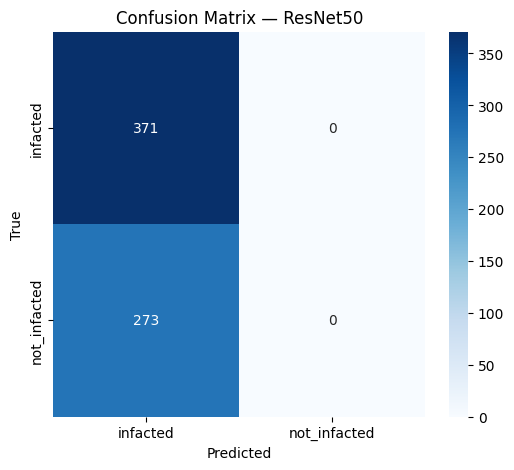

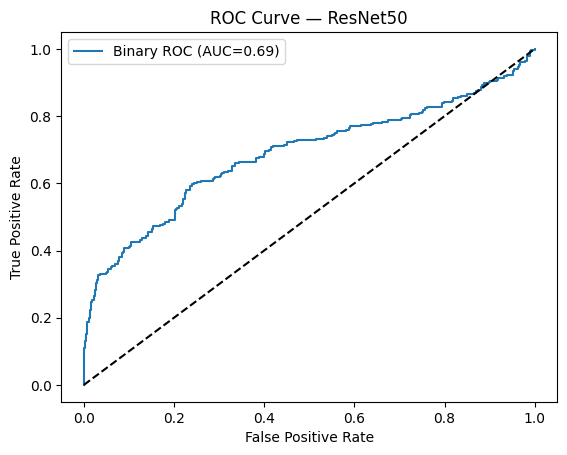


ROC–AUC: 0.6870


I0000 00:00:1761608571.658937      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761608571.659082      19 single_machine.cc:361] Starting new session
I0000 00:00:1761608571.660020      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (40%)
# test (60%)

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

train_df, test_df = train_test_split(
    df,
    test_size=0.6,
    stratify=df["label"],
    random_state=42
)

# Validation = 10% of total dataset → 10 / 40 = 0.25 of train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 462
Validation size: 52
Test size: 773

Train class distribution:
label
infacted        266
not_infacted    196
Name: count, dtype: int64

Validation class distribution:
label
infacted        30
not_infacted    22
Name: count, dtype: int64

Test class distribution:
label
infacted        445
not_infacted    328
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version

Found 462 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.
Found 773 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.4594 - loss: 1.0395 - val_accuracy: 0.4231 - val_loss: 0.8467
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.4790 - loss: 0.8629 - val_accuracy: 0.4231 - val_loss: 0.7313
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5012 - loss: 0.8228 - val_accuracy: 0.5962 - val_loss: 0.6888
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4782 - loss: 0.7891 - val_accuracy: 0.5769 - val_loss: 0.6802
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5440 - loss: 0.7060 - val_accuracy: 0.5769 - val_loss: 0.6805
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5265 - loss: 0.7463 - val_accuracy: 0.5769 - val_loss: 0.6810
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5100 - loss: 0.8281 - val_accuracy: 0.5769 - val_loss: 0.6812
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.4988 - loss: 0.7855 - val_accuracy: 0.5769 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


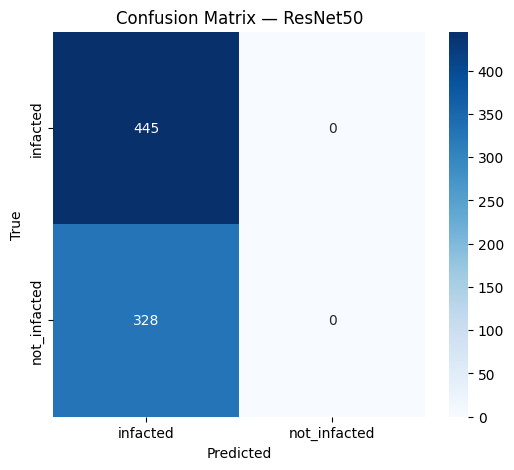

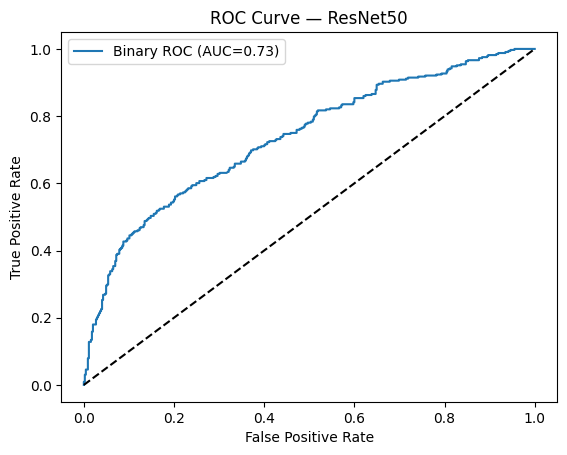


ROC–AUC: 0.7349


I0000 00:00:1761610639.369259      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761610639.369445      19 single_machine.cc:361] Starting new session
I0000 00:00:1761610639.370704      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [23]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (30%)
# test (70%)

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

# Train 90% + Test 10%
train_df, test_df = train_test_split(
    df,
    test_size=0.7,
    stratify=df["label"],
    random_state=42
)

# Validation = 10% of total dataset → 10 / 30 ≈ 0.3333 of train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 347
Validation size: 39
Test size: 901

Train class distribution:
label
infacted        200
not_infacted    147
Name: count, dtype: int64

Validation class distribution:
label
infacted        22
not_infacted    17
Name: count, dtype: int64

Test class distribution:
label
infacted        519
not_infacted    382
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version


Found 347 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.
Found 901 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5134 - loss: 0.7788 - val_accuracy: 0.5641 - val_loss: 0.6916
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4898 - loss: 0.7680 - val_accuracy: 0.5641 - val_loss: 0.6886
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5386 - loss: 0.7665 - val_accuracy: 0.5641 - val_loss: 0.6900
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.4574 - loss: 0.7811 - val_accuracy: 0.5641 - val_loss: 0.6886
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4815 - loss: 0.7577 - val_accuracy: 0.5641 - val_loss: 0.6879
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4793 - loss: 0.7578 - val_accuracy: 0.5641 - val_loss: 0.6876
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4935 - loss: 0.7541 - val_accuracy: 0.5641 - val_loss: 0.6875
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5364 - loss: 0.7114 - val_accuracy: 0.5641 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


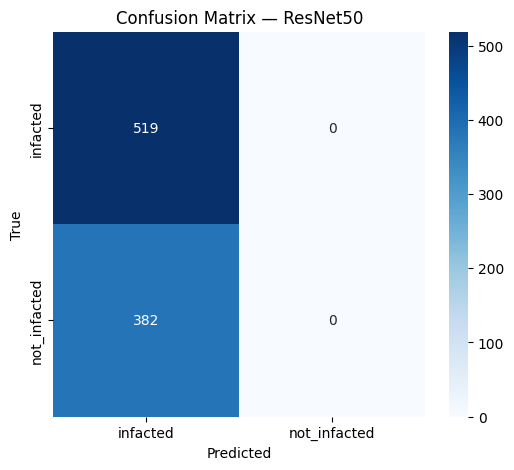

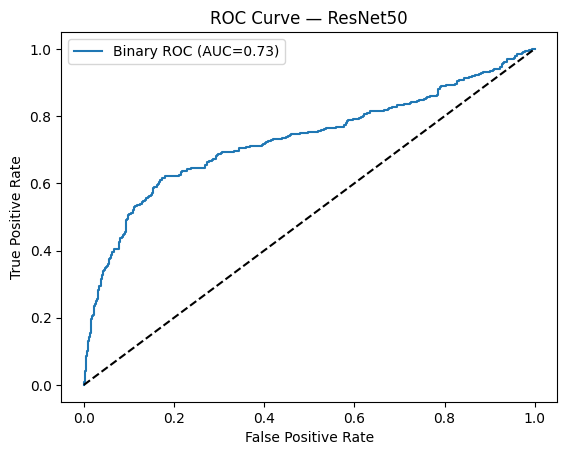


ROC–AUC: 0.7293


I0000 00:00:1761612274.870729      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761612274.870900      19 single_machine.cc:361] Starting new session
I0000 00:00:1761612274.871936      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (20%)
# test (80%)

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: df should have columns ['filepath', 'label', 'group']

# Train 90% + Test 10%
train_df, test_df = train_test_split(
    df,
    test_size=0.8,
    stratify=df["label"],
    random_state=42
)

# Validation = 10% of total dataset → 10 / 20 = 0.5 of train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

# Step 3: Print results
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# Step 4: Save CSVs
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\n Train/Val/Test CSVs saved successfully!")


Train size: 231
Validation size: 26
Test size: 1030

Train class distribution:
label
infacted        133
not_infacted     98
Name: count, dtype: int64

Validation class distribution:
label
infacted        15
not_infacted    11
Name: count, dtype: int64

Test class distribution:
label
infacted        593
not_infacted    437
Name: count, dtype: int64

 Train/Val/Test CSVs saved successfully!


# ResNet50 Version

Found 231 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.
Found 1030 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4961 - loss: 0.7813 - val_accuracy: 0.5769 - val_loss: 0.6846
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5483 - loss: 0.7745 - val_accuracy: 0.5769 - val_loss: 0.6843
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5398 - loss: 0.7549 - val_accuracy: 0.5769 - val_loss: 0.6843
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4756 - loss: 0.8116 - val_accuracy: 0.5769 - val_loss: 0.6844
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5128 - loss: 0.7548 - val_accuracy: 0.5769 - val_loss: 0.6845
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5321 - loss: 0.7568 - val_accuracy: 0.5769 - val_loss: 0.6847
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5248 - loss: 0.7902 - val_accuracy: 0.5769 - val_loss: 0.6850
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4666 - loss: 0.8217 - val_accuracy: 0.5769 - val_loss: 0.6850
Epoch 9/

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


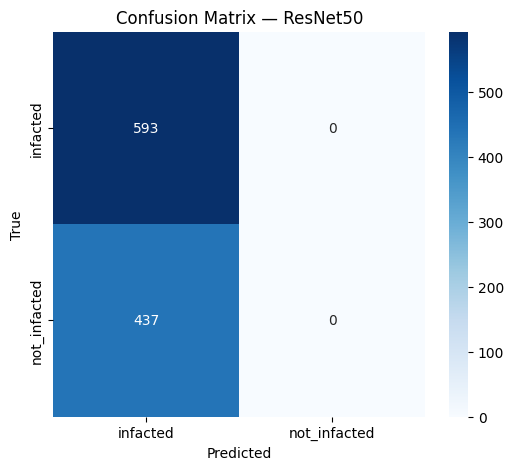

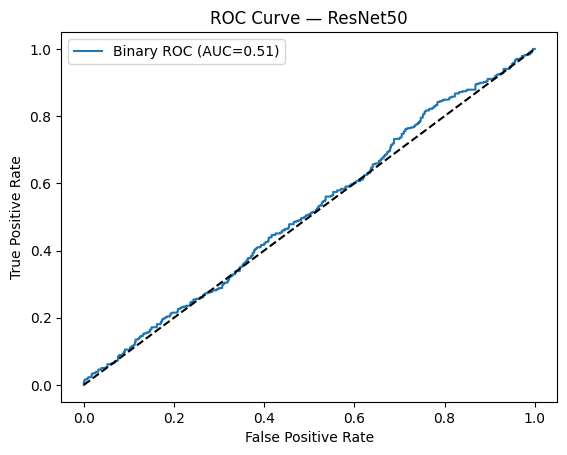


ROC–AUC: 0.5146


I0000 00:00:1761613488.360651      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761613488.360868      19 single_machine.cc:361] Starting new session
I0000 00:00:1761613488.361937      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [27]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")


# Validation Split
# train (10%)
# test (90%)

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

# =======================
# Step 1: Split dataset into Train (10%) and Test (90%)
# =======================
train_df, test_df = train_test_split(
    df,
    test_size=0.9,  # 90% of total dataset for test
    stratify=df["label"],
    random_state=42
)

# =======================
# Step 2: Split Train into Train (90% of train) and Validation (10% of train)
# =======================
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,  # 10% of training portion
    stratify=train_df["label"] if len(train_df) > 1 else None,
    random_state=42
)

# =======================
# Step 3: Print results
# =======================
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts())
print("\nValidation class distribution:")
print(val_df["label"].value_counts())
print("\nTest class distribution:")
print(test_df["label"].value_counts())

# =======================
# Step 4: Save CSVs
# =======================
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

print("\nTrain/Val/Test CSVs saved successfully!")


Train size: 115
Validation size: 13
Test size: 1159

Train class distribution:
label
infacted        66
not_infacted    49
Name: count, dtype: int64

Validation class distribution:
label
infacted        8
not_infacted    5
Name: count, dtype: int64

Test class distribution:
label
infacted        667
not_infacted    492
Name: count, dtype: int64

Train/Val/Test CSVs saved successfully!


# ResNet50 Version

Found 115 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.
Found 1159 validated image filenames belonging to 2 classes.
Classes in train set: {'infacted': 0, 'not_infacted': 1}
Classes in test set: {'infacted': 0, 'not_infacted': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.3999 - loss: 0.8764 - val_accuracy: 0.3846 - val_loss: 0.8013
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5358 - loss: 0.7395 - val_accuracy: 0.3846 - val_loss: 0.7653
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4705 - loss: 0.7972 - val_accuracy: 0.3846 - val_loss: 0.7345
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5592 - loss: 0.7266 - val_accuracy: 0.3846 - val_loss: 0.7111
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4854 - loss: 0.7585 - val_accuracy: 0.3846 - val_loss: 0.6946
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5052 - loss: 0.7340 - val_accuracy: 0.6154 - val_loss: 0.6834
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5535 - loss: 0.7340 - val_accuracy: 0.6154 - val_loss: 0.6762
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5674 - loss: 0.7038 - val_accuracy: 0.6154 - val_loss: 0.6718
Epoch 9/

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


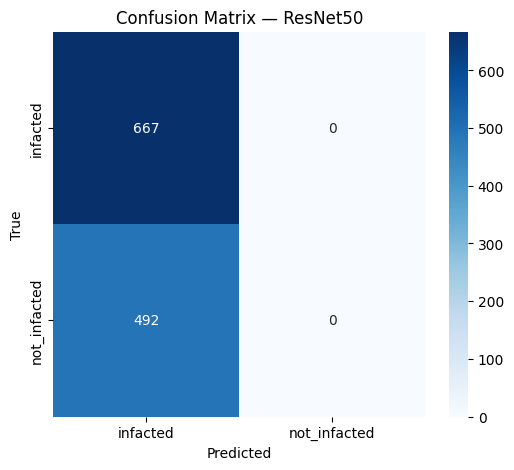

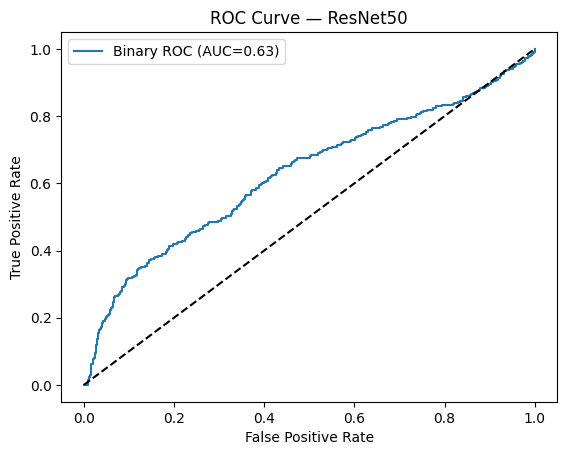


ROC–AUC: 0.6279


I0000 00:00:1761614224.051983      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1761614224.052186      19 single_machine.cc:361] Starting new session
I0000 00:00:1761614224.053252      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [29]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ======= Adjustable Epochs =======
EPOCHS = 50  # 🔁 Change this number anytime
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# ======= Load CSVs =======
train_df = pd.read_csv("/kaggle/working/train_split.csv")
val_df = pd.read_csv("/kaggle/working/val_split.csv")
test_df = pd.read_csv("/kaggle/working/test_split.csv")

# ======= Image Data Generators =======
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="filepath", 
    y_col="label",
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)


# ======= Build ResNet50 Model =======
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


print("Classes in train set:", train_gen.class_indices)
print("Classes in test set:", test_gen.class_indices)


# ======= Train =======
start_train = time.time()
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
train_time = time.time() - start_train

# ======= Evaluate =======
start_test = time.time()
test_loss, test_acc = model.evaluate(test_gen)
test_time = time.time() - start_test

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"⏱ Training Time: {train_time:.2f}s | Testing Time: {test_time:.2f}s")

# ======= Predictions =======
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

# ======= Metrics =======
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======= Confusion Matrix =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======= ROC–AUC for binary classification =======
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Use probability of 'not_infacted' or positive class
y_pred_prob_pos = y_pred_probs[:, 1]  # probability of class 1

auc_score = roc_auc_score(y_true, y_pred_prob_pos)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_pos)

plt.figure()
plt.plot(fpr, tpr, label=f"Binary ROC (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nROC–AUC: {auc_score:.4f}")


# ======= GFLOPs =======
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ======= Suppress TensorFlow GPU info logs =======
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors

# ======= Define your model =======
input_shape = (224, 224, 3)  # Fixed input size
model = ResNet50(input_shape=input_shape, include_top=True, weights=None)

# ======= Convert to ConcreteFunction =======
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec([1, *input_shape], model.inputs[0].dtype)
)

# ======= Freeze the graph =======
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# ======= Use TF Profiler to calculate FLOPs =======
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

# ======= Print GFLOPs per inference =======
print(f"\n⚙️ GFLOPs per inference (input size {input_shape}): {flops.total_float_ops / 1e9:.4f} GFLOPs")
